In [ ]:
import numpy as np
import cv2 as cv
import math
from math import ceil
import collections

In [ ]:
def rgbtoycrcb(img):
  row , col , m = img.shape
  for i in range(row):
    for j in range(col):
      Y[i,j] = 0.299*img[i,j,0] + 0.587*img[i,j,1] + 0.114*img[i,j,2]
      cr[i,j] = -0.169*img[i,j,0] -0.331*img[i,j,1] +0.5*img[i,j,2] + 128
      cb[i,j] = 0.5*img[i,j,0] - 0.419*img[i,j,1] - 0.081*img[i,j,2] + 128
  return Y,cr,cb

In [ ]:
def DCT(Y,row,col):
  c= np.array([[ 0.354,  0.354,  0.354,  0.354,  0.354,  0.354,  0.354,  0.354],
  [ 0.49,   0.416,  0.278,  0.098, -0.098, -0.278, -0.416, -0.49 ],
  [ 0.462,  0.191, -0.191, -0.462, -0.462, -0.191 , 0.191,  0.462],
  [ 0.416, -0.098, -0.49,  -0.278,  0.278,  0.49,   0.098, -0.416],
  [ 0.354, -0.354, -0.354,  0.354,  0.354, -0.354, -0.354,  0.354],
  [ 0.278, -0.49,   0.098,  0.416, -0.416, -0.098,  0.49,  -0.278],
  [ 0.191, -0.462,  0.462, -0.191, -0.191,  0.462, -0.462,  0.191],
  [ 0.098, -0.278,  0.416, -0.49,   0.49,  -0.416,  0.278, -0.098]])
  DCT = np.zeros((row,col),dtype = np.float32)
  c_t = c.transpose()
  for colitr in range (int(col/8)):
        start_col = 8*colitr
        #print(start_col)
        for rowitr in range (int(row/8)):
          start_row = 8*rowitr
          m = Y[start_row:start_row+8,start_col:start_col+8]@c_t
          dct = c@m
          DCT[start_row:start_row+8,start_col:start_col+8] = dct

  return DCT

In [ ]:
def quant(F,QT):
  for c in range(int(col/8)):
    c1 = 8*c
    for r in range(int(row/8)):
      r1 = 8*r
      F[r1:r1+8,c1:c1+8] = np.ceil(F[r1:r1+8,c1:c1+8]/QT)
  return F

In [ ]:
def zigzag(F):
  zigzag = list()

  for rowitr in range(int(row/8)):
    block_x = 8*rowitr
    for colitr in range(int(col/8)):
      block_y = 8*colitr
      count = 1
      after_eight = 0
      next_start_row = 0
      next_start_col = 0
      rev = 0

      while next_start_row < 8 and next_start_col < 8:
        i = 0
        start_row = next_start_row
        start_col = next_start_col
        
        temp = []
        
        while i != count:
          temp.append(F[block_x+start_row-i][block_y+start_col+i])
          
          i = i+1
        if start_row == 7:
          next_start_col = start_col + 1
        else:
          next_start_row = start_row + 1

        if after_eight == 1 : 
          count = count - 1
        else: 
          count = count + 1
        if count == 8:
          after_eight = 1

        if rev == 1:
          temp.reverse()
          #print(temp)
          rev = 0
        else:
          #print(temp)
          rev = 1

        
        zigzag = zigzag + temp

  zigzag = np.array(zigzag)
  zigzag = zigzag.astype(np.int16)  #for getting integer values
  return zigzag


In [ ]:
def encode(zigzag):
  encoded = list()
  run_length = 0
  end = ("END",)
  
  block_done=0
  prev_dc = zigzag[0]
  for j in range(len(zigzag)):
              
              
              if  block_done == 0:  # for the first DC component
                  if j == 0:
                    encoded.append((int(zigzag[j]).bit_length(),))
                    
                  else:
                  
                        diff = int(zigzag[j] - prev_dc)
                        if diff != 0:
                            encoded.append((diff.bit_length(),))
                        else:
                            encoded.append((1, diff))
                  prev_dc = zigzag[j]
                  run_length = 0
                  

              else:
              
                  if zigzag[j] == 0:  # increment run_length by one in case of a zero
                      if run_length == 15:
                        encoded.append((run_length, int(zigzag[j]).bit_length(), zigzag[j]))
                        run_length = 0
                      else:
                          run_length += 1
                  else:  # intermediary steam representation of the AC components
                      encoded.append((run_length, int(zigzag[j]).bit_length(), zigzag[j]))
                      run_length = 0
              if block_done == 63:

                encoded.append(end)
                block_done = 0 
              else:
                block_done+=1


              
              # send EOB
              
  if not (encoded[len(encoded) - 1] == end):
                encoded.append(end)
  return encoded

In [ ]:
def Frequency(encoded):
  Output = collections.defaultdict(int)
  for elem in encoded:
        
          Output[elem[0:2]] += 1
        
  return Output

In [ ]:
import heapq

class node:
	def __init__(self, freq, symbol, left=None, right=None):
		# frequency of symbol
		self.freq = freq

		# symbol name (character)
		self.symbol = symbol

		# node left of current node
		self.left = left

		# node right of current node
		self.right = right

		# tree direction (0/1)
		self.huff = ''
		
	def __lt__(self, nxt):
		return self.freq < nxt.freq
		

# utility function to print huffman
# codes for all symbols in the newly
# created Huffman tree

def huffmann(a):
  huffmann_codes = collections.defaultdict(int)

  def getCodes(node, val=''):
    
    # huffman code for current node
    newVal = val + str(node.huff)

    # if node is not an edge node
    # then traverse inside it
    if(node.left):
      getCodes(node.left, newVal)
    if(node.right):
      getCodes(node.right, newVal)

      # if node is edge node then
      # display its huffman code
    if(not node.left and not node.right):
                      huffmann_codes[node.symbol] = newVal
                      
                      #print(f"{node.symbol} -> {newVal}")
                              





  # list containing unused nodes
  nodes = []

  # converting characters and frequencies
  # into huffman tree nodes
  for k in a:
    heapq.heappush(nodes, node(a[k], k[0:2]))
    


  #Creating Huffman Tree 
  while len(nodes) > 1:
    
    # sort all the nodes in ascending order
    # based on their frequency
    left = heapq.heappop(nodes)
    right = heapq.heappop(nodes)

    # assign directional value to these nodes
    left.huff = 0
    right.huff = 1

    # combine the 2 smallest nodes to create
    # new node as their parent
    newNode = node(left.freq+right.freq, left.symbol+right.symbol, left, right)

    heapq.heappush(nodes, newNode)


  getCodes(nodes[0])
  return huffmann_codes


In [ ]:
def compress_data(encoded,huffmann_codes):
  i= 0 
  compress = str()
  for elem in encoded:
    if i == len(encoded) - 1:
      break
    if len(elem) <=2 :
      compress+=huffmann_codes[elem]
      i +=1
    else:
      st = bin(elem[2])

      if elem[2] < 0:
        for i in range(len(st)):
          if st[i] == "0" :
            st = st[0:i]+"1"+st[i+1:]
          else: st = st[0:i]+"0"+st[i+1:]
        compress+=huffmann_codes[elem[0:2]] + st[3:]
        

      else:
        compress+=huffmann_codes[elem[0:2]] + st[2:]
      i+=1

  
  return compress

In [ ]:
img = cv.imread("/content/as.png", cv.IMREAD_COLOR)
row , col , m = img.shape
padr = ceil(row/8)*8
padc = ceil(col/8)*8

Y = np.zeros((padr, padc), np.float32) 
cr = np.zeros((padr, padc), np.float32) 
cb = np.zeros((padr, padc), np.float32)

Y,cr,cb=rgbtoycrcb(img)
Y = Y - 128
cr = cr - 128
cb = cb - 128

row = padr
col = padc


DCb = np.zeros((row,col),dtype = np.float32)
DCr = np.zeros((row,col),dtype = np.float32)
DY = DCT(Y,row,col)
DCb = DCT(cb,row,col)
DCr = DCT(cr,row,col)
lum = np.array([[16, 11, 10, 16, 24, 40, 51, 61], 
                [12, 12, 14, 19, 26, 48, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])
# 8 block dct 
chro = np.array([[17, 18, 24, 47, 99, 99, 99, 99],  # chrominance quantization table
                [18, 21, 26, 66, 99, 99, 99, 99],
                [24, 26, 56, 99, 99, 99, 99, 99],
                [47, 66, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99]])
qy = quant(DY,lum)
qcr = quant(DCr,chro)
qcb = quant(DCb,chro)

zy = zigzag(qy)
zcb = zigzag(qcb)
zcr = zigzag(qcr)

y_encoded = encode(zy)
cb_encoded = encode(zcb)
cr_encoded = encode(zcr)

fy = Frequency(y_encoded)
fcb = Frequency(cb_encoded)
fcr = Frequency(cr_encoded)
hy = huffmann(fy)
hcb = huffmann(fcb)
hcr = huffmann(fcr)

    
y_compressed = compress_data(y_encoded,hy)
cb_compressed = compress_data(cb_encoded,hcb)
cr_compressed = compress_data(cr_encoded,hcr)


def Inbytes(compress):
  y = len(compress)%8
  if y!=0:
    compress += "0"*(8-y)

  Byte = bytes()
  num=0
  for i in range(0, len(compress) - 1, 8):
          num = int(compress[i:i+8],base=2)
        
          chr = num.to_bytes(1, 'little')
          Byte += chr
  return Byte

Byte_qy = bytes()

Byte_qc = bytes()

for i in range(8):
  for j in range(8):
    Byte_qy += str(lum[i,j]).encode()
    Byte_qc += str(chro[i,j]).encode()
           
        
        
bytedata = bytes()

bytedata+=Inbytes(y_compressed)
bytedata+=Inbytes(cb_compressed)
bytedata+=Inbytes(cr_compressed)

huffmann_tables = bytes()
huffmann_tables = str(hy).encode() + str(hcb).encode() + str(hcr).encode()
bytedata = b'\xFFD8'+ b'\xFFC0'+ str((row,col)).encode()+ b'\xFFDB' + Byte_qy + b'\xFFDB' + Byte_qc + b'\xFFC4' + huffmann_tables  + b'\x00' +bytedata + b'\xFFD9'
print(bytedata)
with open('file.txt','wb') as data: 
      data.write(bytedata)

b'\xffD8\xffC0(512, 512)\xffDB1611101624405161121214192648605514131624405769561417222951878062182237566810910377243555648110411392496478871031211201017292959811210010399\xffDB17182447999999991821266699999999242656999999999947669999999999999999999999999999999999999999999999999999999999999999999999999999\xffC4defaultdict(<class \'int\'>, {(0, 1): \'0\', (1, 1): \'10\', (\'END\',): \'11000\', (5, 1): \'110010\', (0, 4): \'1100110\', (4,): \'11001110\', (5,): \'11001111\', (0, 2): \'11010\', (0, 3): \'110110\', (1,): \'11011100\', (0, 5): \'110111010\', (1, 3): \'1101110110\', (6,): \'1101110111\', (2,): \'11011110\', (3,): \'11011111\', (4, 1): \'111000\', (6, 1): \'11100100\', (1, 2): \'11100101\', (1, 0): \'111001100\', (1, 4): \'111001101000\', (10, 1): \'111001101001\', (9, 1): \'11100110101\', (8, 1): \'1110011011\', (7, 1): \'111001110\', (2, 2): \'1110011110\', (11, 1): \'1110011111000\', (6, 2): \'1110011111001000\', (4, 3): \'111001111100100100\', (5, 3): \'111001111100100101\', 

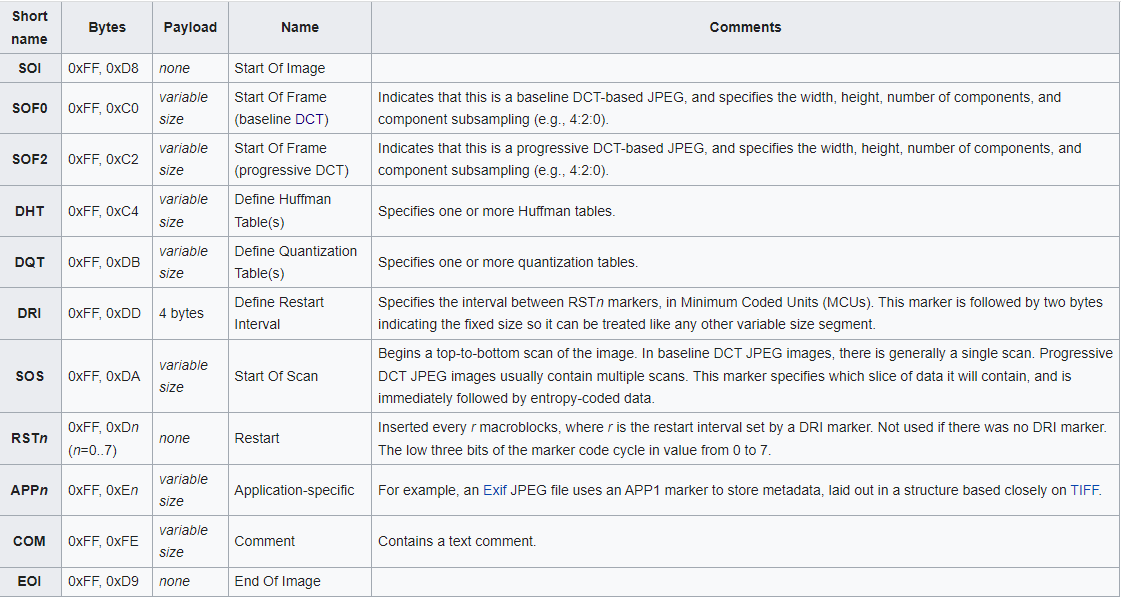